In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define a transform to normalize the data
transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
dataset = torchvision.datasets.MNIST(root="./root", train = True, download=True, transform=transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.26MB/s]


In [7]:
!nvidia-smi

Sun Dec  7 12:34:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
img, label = dataset[0]
# Move the image to the device
print(f"Image shape: {img.shape}, Label: {label}")

Image shape: torch.Size([1, 28, 28]), Label: 5


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, Latent_dim):
        super().__init__()
        self.en_f = nn.Linear(input_dim, hidden_dim)
        self.en_mu = nn.Linear(hidden_dim, Latent_dim)
        self.en_logvar = nn.Linear(hidden_dim, Latent_dim)
        self.re_f = nn.Linear(Latent_dim, hidden_dim)
        self.re_out = nn.Linear(hidden_dim, input_dim)

    def reparametersize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        hidden = F.relu(self.en_f(x.view(x.size(0), -1))) # 把图像展平
        mu = self.en_mu(hidden)
        logvar = self.en_logvar(hidden)

        z = self.reparametersize(mu, logvar=logvar)

        re_en = F.relu(self.re_f(z))
        out = self.re_out(re_en)
        return F.sigmoid(out).view(*x.size()), mu, logvar

    def decoder(self, z):
        re_en = F.relu(self.re_f(z))
        out = F.sigmoid(self.re_out(re_en))
        return out

In [ ]:
import torch.utils.data
from torch.optim import optimizer
model = VAE(1 * 28 * 28, 256, 20).to(device)
train_data = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [26]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import swanlab
# 假设您在其他地方定义了 model, optimizer, train_data, device

# ... swanlab.init() 和 num_epochs 定义不变 ...

num_epochs = 50
model.train()

for i in range(num_epochs): # i 代表当前 epoch 索引 (0 到 199)
    # 🎯 追踪本 Epoch 的累积损失
    total_epoch_loss = 0
    total_epoch_bce = 0
    total_epoch_kld = 0

    # 确保 optimizer 变量名正确
    # 假设您的优化器变量名为 optimizer (如果仍是 optemizer，请修正)

    for batch_idx, (batch_imgs, batch_labels) in enumerate(train_data):
        batch_imgs = batch_imgs.to(device)

        # 1. 前向传播
        recon_batch, mu, logvar = model(batch_imgs)

        # 2. 梯度清零
        optimizer.zero_grad()

        # 3. 损失计算
        BCE = torch.sum(F.binary_cross_entropy(recon_batch, batch_imgs, reduction='none'), dim=(1, 2, 3))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

        # KL 退火权重：在 0 到 1 之间线性增长
        kl_weight = i / num_epochs

        # VAE Loss：对 BCE + 加权 KLD 的结果进行批量平均
        loss = torch.mean(BCE + kl_weight * KLD)

        # 4. 反向传播与优化
        loss.backward()
        optimizer.step()

        # 5. 累加损失（用于 Epoch 总结）
        # loss.item() 是批量平均损失，需要乘以批量大小（或仅累加平均损失）
        # 这里累加平均损失，最后除以总批次数量，得到平均损失
        total_epoch_loss += loss.item()
        total_epoch_bce += BCE.mean().item()
        total_epoch_kld += KLD.mean().item()

        # 6. 记录到 SwanLab (可选：只记录 Batch 级别的瞬时值)
        # SwanLab 适合记录每个 Batch 的瞬时数据，以便在图表上看到详细波动
        swanlab.log({
            "batch_loss/loss": loss.item(),
            "batch_loss/BCE": BCE.mean().item(),
            "batch_loss/KLD": KLD.mean().item()
        })

        # 🚨 可选：如果您仍想看一些进度，可以每隔 N 个 Batch 打印一次：
        # if batch_idx % 100 == 0:
        #     print(f"Epoch [{i+1}/{num_epochs}], Batch [{batch_idx}/{len(train_data)}], Loss: {loss.item():.4f}")


    # 7. 每个 Epoch 结束时的总结操作
    avg_epoch_loss = total_epoch_loss / len(train_data)
    avg_epoch_bce = total_epoch_bce / len(train_data)
    avg_epoch_kld = total_epoch_kld / len(train_data)

    # 🎯 记录 Epoch 级别的平均损失
    swanlab.log({
        "epoch_loss/avg_loss": avg_epoch_loss,
        "epoch_loss/avg_BCE": avg_epoch_bce,
        "epoch_loss/avg_KLD": avg_epoch_kld
    }, step=i)

    # 打印最终的 Epoch 总结
    print(f"--- Epoch [{i+1}/{num_epochs}] Summary ---")
    print(f"Avg Loss: {avg_epoch_loss:.4f}, Avg BCE: {avg_epoch_bce:.4f}, Avg KLD: {avg_epoch_kld:.4f}")

    # 8. 保存模型
    torch.save(model.state_dict(), 'model.pt')
    print(f"Model saved at epoch {i+1}.")

--- Epoch [1/50] Summary ---
Avg Loss: 69.4405, Avg BCE: 69.4405, Avg KLD: 100.9237
Model saved at epoch 1.
--- Epoch [2/50] Summary ---
Avg Loss: 70.1891, Avg BCE: 68.3007, Avg KLD: 94.4236
Model saved at epoch 2.
--- Epoch [3/50] Summary ---
Avg Loss: 70.9179, Avg BCE: 68.4515, Avg KLD: 61.6592
Model saved at epoch 3.
--- Epoch [4/50] Summary ---
Avg Loss: 71.9367, Avg BCE: 68.5376, Avg KLD: 56.6516
Model saved at epoch 4.
--- Epoch [5/50] Summary ---
Avg Loss: 72.9206, Avg BCE: 68.6409, Avg KLD: 53.4967
Model saved at epoch 5.
--- Epoch [6/50] Summary ---
Avg Loss: 73.8586, Avg BCE: 68.7373, Avg KLD: 51.2131
Model saved at epoch 6.
--- Epoch [7/50] Summary ---
Avg Loss: 74.8041, Avg BCE: 68.8839, Avg KLD: 49.3349
Model saved at epoch 7.
--- Epoch [8/50] Summary ---
Avg Loss: 75.7599, Avg BCE: 69.0594, Avg KLD: 47.8606
Model saved at epoch 8.
--- Epoch [9/50] Summary ---
Avg Loss: 76.5953, Avg BCE: 69.1589, Avg KLD: 46.4771
Model saved at epoch 9.
--- Epoch [10/50] Summary ---
Avg Lo

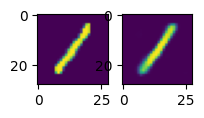

In [30]:
import matplotlib.pyplot as plt
import random

model.eval()
with torch.no_grad():
    img,_=dataset[random.randint(0,len(dataset))]
    recon_x,mu,logvar=model(img.unsqueeze(0).to(device))

plt.figure(figsize=(2,2))
plt.subplot(1,2,1)
plt.imshow(img.view(28,28).numpy())
plt.subplot(1,2,2)
plt.imshow(recon_x.view(28,28).cpu().numpy())

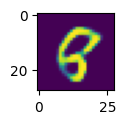

In [38]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    latent=torch.randn(1,20).to(device)
    recon_x=model.decoder(latent)
plt.figure(figsize=(1,1))
plt.imshow(recon_x.view(28,28).cpu().numpy())